<a href="https://colab.research.google.com/github/yvrjsharma/Transformers/blob/main/Transformers_Attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy torchtext

Transformer was the first transduction model relying entirely on self-attention to compute representations iof its input and output without using sequence aligned RNNs or Convolutions. (*from paper*)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy 
from torch.autograd import Variable

#For Plots
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class EncoderDecoder(nn.Module):
  """ A standard encoder-decoder architecture """
  def __init__(self, encoder, decoder,src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def forward(self, src, tgt, src_mask, tgt_mask):
    #take in and process masked spource and target sequences
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self,memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


In [3]:
class Generator(nn.Module):
  #Defining standard linear and softmax generation step
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)
  
  def forward(self,x):
    return F.log_softmax(self.proj(x),dim=-1) 

## Encoder - Decoder Stack 
### Encoder consists of 6 identical layers

In [4]:
def clones(module, N=6):
  "Creates N identical layers of the type"
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class Encoder(nn.Module):
  #Coding for encoder block
  def __init__(self,layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self,x, mask):
    "Pass input and mask through each layer by turn"
    for layer in self.layers:
      x =  layer(x, mask)
    return self.norm(x)

Applying residual layer and normalization layers

In [6]:
class LayerNorm(nn.Module):
  def __init__(self,features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps=eps

  def forward(self,x):
    mean= x.mean(-1, keepdim=True)
    std= x.std(-1,keepdim=True)
    return self.a_2*(x-mean)/(std+self.eps) +self.b_2

In [7]:
class SublayerConnection(nn.Module):
  "Residual connection added to Layer Norm"
  def __init__(sel,size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x, sublayer):
    "Apply residual connections"
    return x + self.dropout(sublayer(self.norm(x)))

Encoder Block :


In [8]:
class EncoderLayer(nn.Module):
  "Encoder is made of Self-Attention and feed forward network"
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward =  feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout),2)
    self.size = size

  def forward(self, x, mask):
    "Encoder block"
    x = self.sublayer[0](x, lambda x:self.self_attn(x,x,x, mask))
    return self.sublayer[1](x, self.feed_forward)

## Decoder

In [9]:
class Decoder(nn.Module):
  "N layer Decoder with masking"
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer, size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)



Decoder has an additional layer which performs muli-head attention on the encoder's output. SO there are three layers in Decoder - Multi-headed masked attention layer, multi-headed attention on Encoder's input, and feed-forward layer.
Also, note that there is a residual connection around each layer, follwoed by a LayerNorm.

In [10]:
class DecoderLayer(nn.Module):
  "Decoder is made of self-attn, src-attn, and feed-forward layers"
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self ).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout),3)
  
  def forward(self,x,memory, src_mask, tgt_mask):
    "Decoder achitecture"
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x,m,m,src_mask))
    return self.sublayer[2](x, self.feed_forward)

Now to implement masking for Decoder inputs - to make sure that Decoder is not attending to subsequent input position than what it is processing right now.

In [11]:
def subsequent_mask(size):
  "MAsking subsequent positions"
  attn_shape = (1,size, size)
  subsequent_mask = np.triu(np.ones(attn_shape),k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0

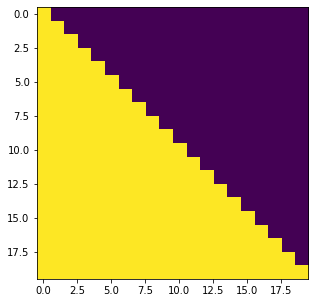

In [14]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])